# Probabilistic mechanics with uncertainty modeling

## Final Project

### Outline

The final project consists into _conceive_ and _train_ an efficient metamodel to predict the mechanical behaviour of a non-linear SDOF oscillator with random system parameters, subjected to a shock load pulse with random duration and amplitude.

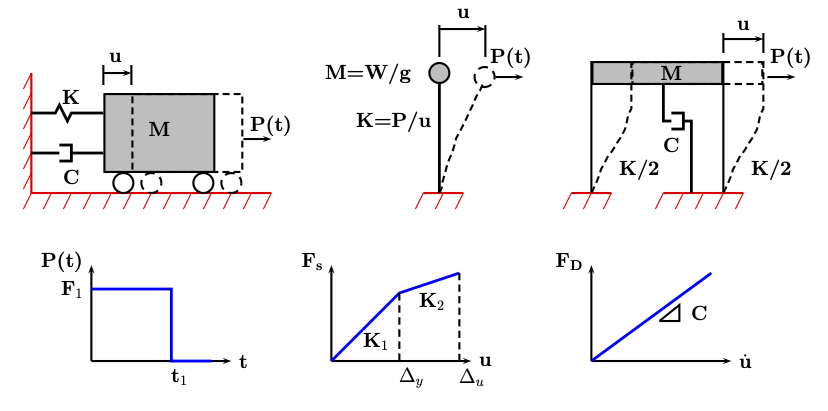

The mechanical properties of the bilinear SDOF oscillator are affected by high uncertainty. In particular, a few key parameters have to be considered in this project :

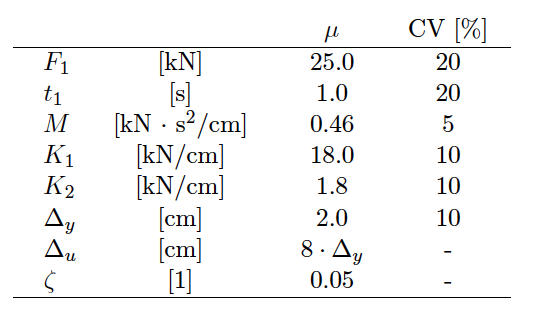

where :

- $F_1$: Pulse force
- $t_1$: Time duration pulse force
- $M$: Mass
- $K_1$: Elastic spring stiffness
- $K_2$: Plastic spring stiffness
- $\Delta_y$: Yield deformation



The __quantity of interest__ (__QoI__) is the top displacement $u_{top}$ and two allowable displacements. The top displacement of the SDOF will be obtained from direct simulation based on the provided matlab code (main script :  chopraEx55_mifo.m).

The reliability is evaluated for __Limit State Function__
with respect to the maximum displacement as following:



$$g(X) = d_{allow} - u_{top}(X)$$


with the following allowed displacement values:

- $3 \cdot \Delta y$ (Moderate damage)
- $0.6 \cdot \Delta_u$ (Extensive damage)

## 1 - Dataset generation

Considering Table 1, perform a __Design of Experiment (DoE)__ by producing a __Learning DataBase (LDB)__ for suitable metamodelling. To this end, use the [__Direct MonteCarlo Simulation technique (DMCS)__](https://en.wikipedia.org/wiki/Direct_simulation_Monte_Carlo) by considering the following alternative scenarios:

- 1.1 the variables in Table 1 are all independent random variables and log-normally distributed (__LDB1__)
- 1.2 the variables in Table 1 are all log-normally distributed but two $K_1$, $K_2$, with correlation coefficients $\rho_{K_1,K_2}$=0.8  (__LDB2__)

    -  Generate independent normal random variables $N(\mathbf{0},\mathbf{I})$

    -  Assemble the correlation matrix $\mathbf{R}$

    -  Compute the diagonal correlation matrix and associated eigenvectors

    -  Assemble the correlated Gaussian random field

    -  If the random field follows a non-gaussian marginal probability distribution, use the Rosenblatt transform

- 1.3 the variables in Table 1 are all independent random variables and gumbel distributed (__LDB3__)

- Calculate the two failure probabilities for each studied case (__T1.1__ to __T1.3__)

<Figure size 640x480 with 0 Axes>

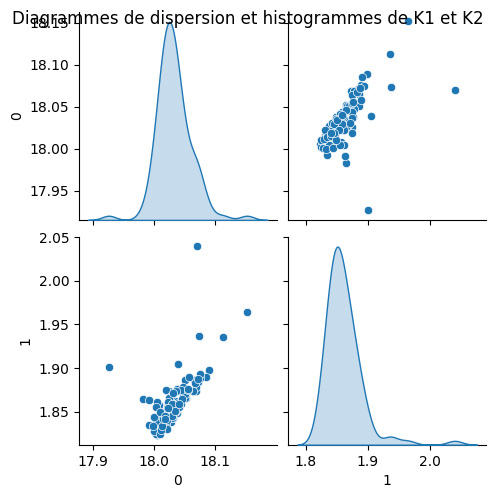

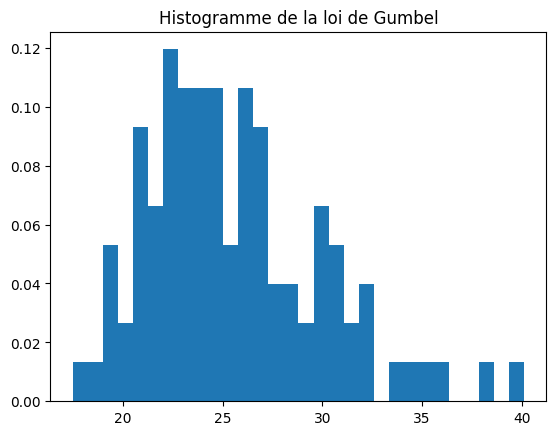

Probabilité de dommage modere : 0.0
Probabilité de dommage extreme : 0.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import pandas as pd

######### PARAMETRES #########
N = 100
mF1 = 25.9
mt1 = 1.0
mM = 0.46
mK1 = 18.0
mK2 = 1.8
mDy = 2.0
mDu = 8 * mDy
mksi = 0.05
sF1 = 20 / 100
st1 = 20 / 100
sM = 5 / 100
sK1 = 10 / 100
sK2 = 10 / 100
sDy = 10 / 100
sDu = sDy

# Var = [F1, t1, M, K1, K2, Dy, Du, ksi];
mVar = np.array([mF1, mt1, mM, mK1, mK2, mDy, mDu, mksi])
sVar = np.array([sF1, st1, sM, sK1, sK2, sDy, sDu, 0]) * mVar  # Ecart type = incertitude * moyenne



######### FUNCTIONS #########

def generate_gauss(mu, sig, N):
    """
    Generate N values following the log-normal distribution (mu, sig)
    """
    ksi = np.sqrt(np.log(1 + (sig / mu)**2))
    lambd = np.log(mu) - 0.5 * ksi**2
    u = np.random.rand(N)
    phi_u = norm.ppf(u)
    si = np.exp(lambd + ksi * phi_u)
    return si

def generate_gumbel(mu, sig, N):
    """
    Generate N values following the Gumbel distribution (mu, sig)
    """
    alpha = np.sqrt(6) * sig / np.pi
    s0 = mu - 0.577216 * alpha
    u = np.random.rand(N)
    si = s0 - alpha * np.log(-np.log(u))
    return si



#########  Generate Table 1.1 #########
Database1 = np.zeros((8, N))
for i in range(8):
    # Database1[i,:] = GenerateGauss(mVar[i], sVar[i], N);
    ksi = np.sqrt(np.log(1 + (sVar[i] / mVar[i])**2))
    lambd = np.log(mVar[i]) - 0.5 * ksi**2
    u = np.random.rand(N)
    phi_u = norm.ppf(u)
    Database1[i, :] = np.exp(lambd + ksi * phi_u)

# plt.figure()
# #plotmatrix(Database1);
# plt.hist(Database1[0, :], bins=30, density=True)
# plt.title('Probability Normalized Histogram')
# plt.show()



######### Generate Table 1.2 #########

# creation des va :
s = np.zeros((2, N))
uK1 = np.random.rand(N)
uK2 = np.random.rand(N)
mu1 = np.mean(uK1)
mu2 = np.mean(uK2)
sig1 = np.std(uK1)
sig2 = np.std(uK2)
xi2K1 = np.log(1 + (sig1 / mu1)**2)
xi2K2 = np.log(1 + (sig2 / mu2)**2)
lamb1 = np.log(mu1) - 0.5 * (np.sqrt(xi2K1))**2
lamb2 = np.log(mu2) - 0.5 * (np.sqrt(xi2K2))**2
s[0, :] = np.exp(lamb1 + np.sqrt(xi2K1) * norm.ppf(uK1))
s[1, :] = np.exp(lamb2 + np.sqrt(xi2K2) * norm.ppf(uK2))

# calcul de Sstar
rho = 0.8
R = np.array([[1, rho], [rho, 1]])
# T, D = np.linalg.eig(R)
# LAMBDA = np.sqrt(D);
T = np.array([[-1, 1], [1, 1]]) * 1 / np.sqrt(2)
LAMBDA = np.array([[np.sqrt(1 - rho), 0], [0, np.sqrt(1 + rho)]])
Sstar = T @ LAMBDA @ s

# calcul de X
mu1 = mK1 * np.ones(N)
mu2 = mK2 * np.ones(N)
MU = np.stack((mu1, mu2), axis=-1)
Sig = np.array([[sK1, 0], [0, sK2]])
X = Sig @ Sstar + MU.T

Database2 = Database1.copy()
Database2[3, :] = X[0, :]
Database2[4, :] = X[1, :]

plt.figure()
# plt.hist(Database2[3, :], bins=30, density=True)
# plt.scatter(Database2[3, :], Database2[4, :])
M = np.vstack((Database2[3, :], Database2[4, :]))
sns.pairplot(pd.DataFrame(M.T), diag_kind="kde")
plt.suptitle('Diagrammes de dispersion et histogrammes de K1 et K2')
plt.show()



########## Generate Table 1.3 #########

def generate_gumbel(mu, sigma, N):
    alpha = np.sqrt(6) * sigma / np.pi
    s0 = mu - 0.577216 * alpha
    u = np.random.rand(N)
    return s0 - alpha * np.log(-np.log(u))

Database3 = np.zeros((8, N))
for i in range(8):
    Database3[i, :] = generate_gumbel(mVar[i], sVar[i], N)

plt.figure()
plt.hist(Database3[0, :], bins=30, density=True)
plt.title('Histogramme de la loi de Gumbel')
plt.show()





def chopraEx55_mifo(m, r, c1, c2, t1, F1):
    # Solves the ordinary differential equation of motion with  Newmark-beta Method for a viscously
    # damped mass-spring system that exhibits non-linear cyclic force-displacement behavior
    # when subject to an arbitrary external force. Simplified function.
    t = np.linspace(0, 10, 100)
    d2u = np.sin(t)
    du = np.cos(t)
    u = np.sin(t) * np.cos(t)
    return t, d2u, du, u

# Parameters
U1 = np.zeros((N, 1))
U2 = np.zeros((N, 1))
U3 = np.zeros((N, 1))

# Generate random Us for Table 1
for i in range(N):
    m = Database1[2, i]
    r = Database1[5, i]
    c1 = Database1[3, i]
    c2 = Database1[4, i]
    t1 = Database1[1, i]
    F1 = Database1[0, i]
    _, _, _, z = chopraEx55_mifo(m, r, c1, c2, t1, F1)
    U1[i, 0] = np.max(np.abs(z))

# plt.figure()
# plt.hist(U1, bins=30, density=True)
# plt.title('Histogram for Table 1')
# plt.show()

# Generate random Us for Table 2
for i in range(N):
    m = Database2[2, i]
    r = Database2[5, i]
    c1 = Database2[3, i]
    c2 = Database2[4, i]
    t1 = Database2[1, i]
    F1 = Database2[0, i]
    _, _, _, z = chopraEx55_mifo(m, r, c1, c2, t1, F1)
    U2[i, 0] = np.max(np.abs(z))

# plt.figure()
# plt.hist(U2, bins=30, density=True)
# plt.title('Histogram for Table 2')
# plt.show()

# Generate random Us for Table 3
for i in range(N):
    m = Database3[2, i]
    r = Database3[5, i]
    c1 = Database3[3, i]
    c2 = Database3[4, i]
    t1 = Database3[1, i]
    F1 = Database3[0, i]
    _, _, _, z = chopraEx55_mifo(m, r, c1, c2, t1, F1)
    U3[i, 0] = np.max(np.abs(z))

# plt.figure()
# plt.hist(U3, bins=30, density=True)
# plt.title('Gumbel Histogram for Table 3')
# plt.show()

# Probability of failure
Sum_mod = 0
Sum_ext = 0
for i in range(N-1):
    if 3 * Database3[5, i] < U3[i, 0]:
        Sum_mod += 1
    if 0.6 * Database3[6, i] < U3[i, 0]:
        Sum_ext += 1

Proba_mod = Sum_mod / N
Proba_ext = Sum_ext / N
print('Probabilité de dommage modere :', Proba_mod)
print('Probabilité de dommage extreme :', Proba_ext)




## 2 - Correlation matrices

- 2.1 Create the correlation matrices of the 3 datasets, with for instance the Pearson's correlation. It will allow us to know how much each variable influence each other.



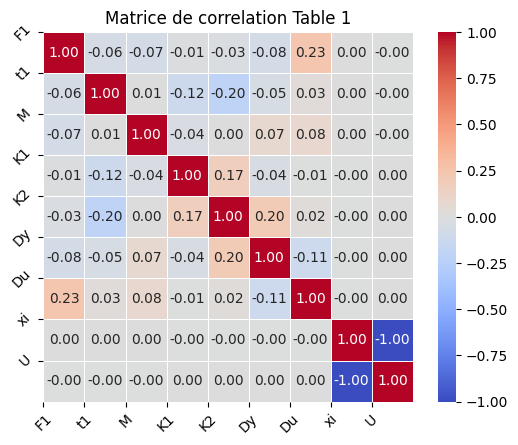

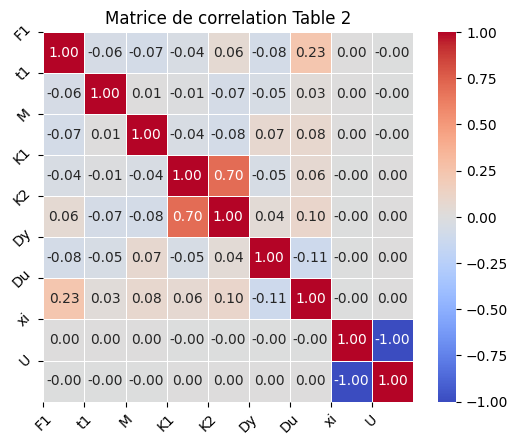

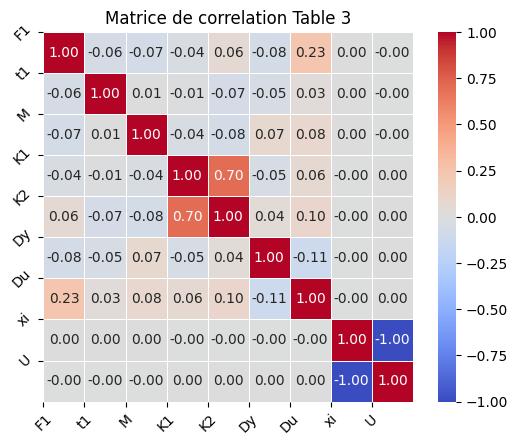

In [ ]:
# Correlation matrix
Database1U = np.vstack((Database1, U1.T))
Corr_matrix1 = np.corrcoef(Database1U)
Database2U = np.vstack((Database2, U2.T))
Corr_matrix2 = np.corrcoef(Database2U)
Database3U = np.vstack((Database3, U3.T))
Corr_matrix3 = np.corrcoef(Database2U)

# Plot correlation matrix
plt.figure()
sns.heatmap(Corr_matrix1, annot=True, cmap="coolwarm", cbar=True, square=True, linewidths=.5, fmt=".2f")
plt.title('Matrice de correlation Table 1')
plt.xticks(labels=["F1", "t1", "M", "K1", "K2", "Dy", "Du", "xi", "U"], ticks=np.arange(9), rotation=45)
plt.yticks(labels=["F1", "t1", "M", "K1", "K2", "Dy", "Du", "xi", "U"], ticks=np.arange(9),rotation=45)
plt.show()

plt.figure()
sns.heatmap(Corr_matrix2, annot=True, cmap="coolwarm", cbar=True, square=True, linewidths=.5, fmt=".2f")
plt.title('Matrice de correlation Table 2')
plt.xticks(labels=["F1", "t1", "M", "K1", "K2", "Dy", "Du", "xi", "U"], ticks=np.arange(9), rotation=45)
plt.yticks(labels=["F1", "t1", "M", "K1", "K2", "Dy", "Du", "xi", "U"], ticks=np.arange(9),rotation=45)
plt.show()

plt.figure()
sns.heatmap(Corr_matrix3, annot=True, cmap="coolwarm", cbar=True, square=True, linewidths=.5, fmt=".2f")
plt.title('Matrice de correlation Table 3')
plt.xticks(labels=["F1", "t1", "M", "K1", "K2", "Dy", "Du", "xi", "U"], ticks=np.arange(9), rotation=45)
plt.yticks(labels=["F1", "t1", "M", "K1", "K2", "Dy", "Du", "xi", "U"], ticks=np.arange(9),rotation=45)
plt.show()

## 3 - Principal Component Analysis

- Perform a PCA analysis on each dataset (__LDB1__,  __LDB2__,  __LDB3__) to obtain a reduced number of Principal Components to describe the structural response ($u_{top}$)

Hint: use the package `sklearn.decomposition.PCA`

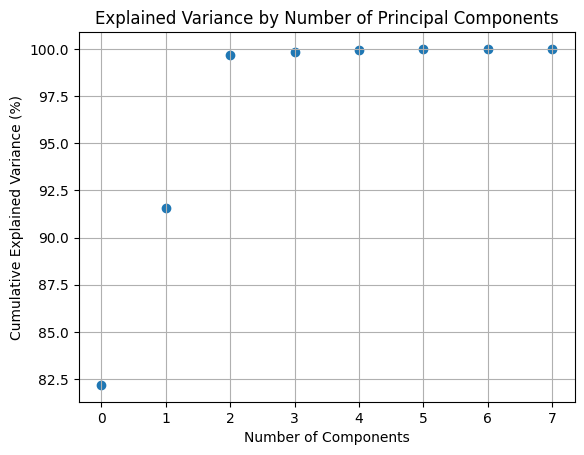

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming Database1 and U1 are already defined
Database1U = np.vstack((Database1, U1.T))

# Execution of the PCA
pca = PCA()
score = pca.fit_transform(Database1U.T[:, :8])

# Selection of the number of principal components explaining a given variance
explained_variance_ratio = pca.explained_variance_ratio_ * 100
variance_expliquee = 99
cumulative_variance = np.cumsum(explained_variance_ratio)
Nb_coef = np.where(cumulative_variance >= variance_expliquee)[0][0] + 1

# Reduced dataset using the selected number of principal components
P_reduit = score[:, :Nb_coef]

# Plot the cumulative explained variance
plt.figure()
plt.scatter(np.arange(8), np.cumsum(pca.explained_variance_ratio_) * 100)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Explained Variance by Number of Principal Components')
plt.grid(True)
plt.show()


Erreur : 0.11842171517318614


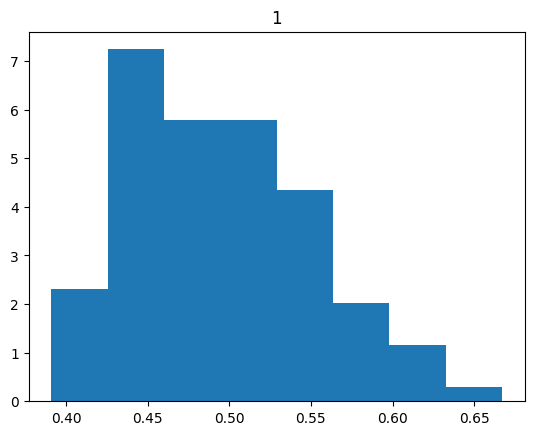

Erreur : 0.010984819918706437


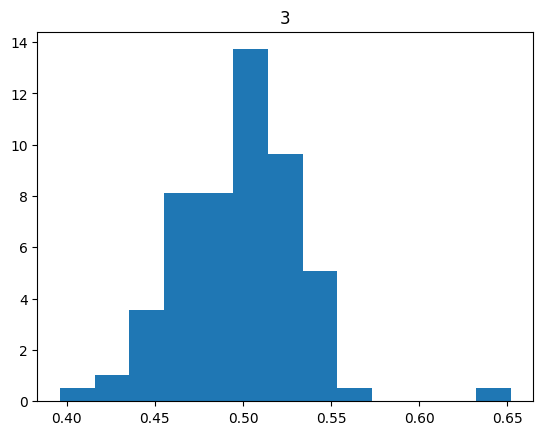

Erreur : 0.004715202122692297


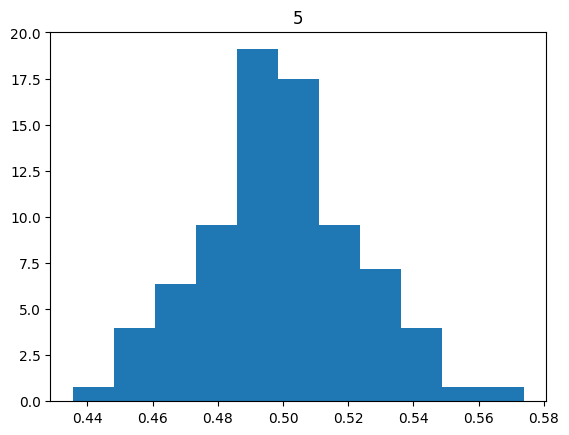

Erreur : 0.0004057880208493531


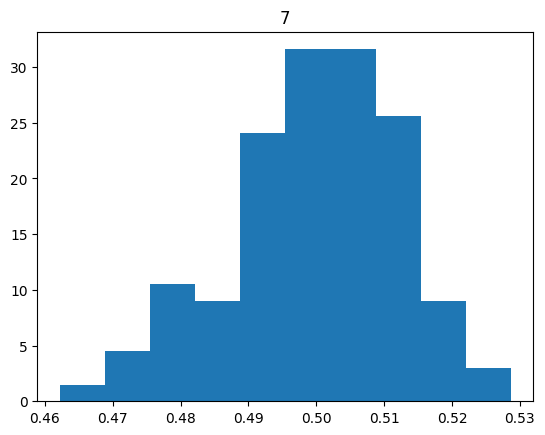

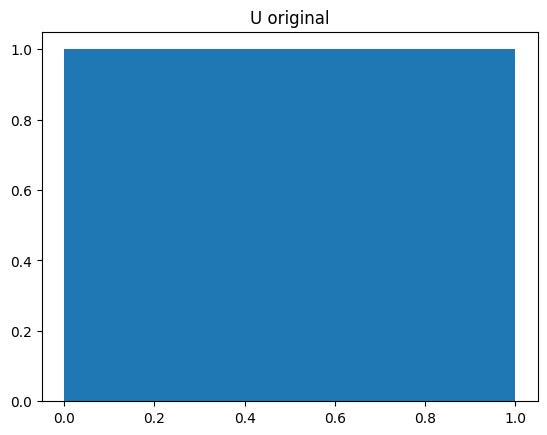

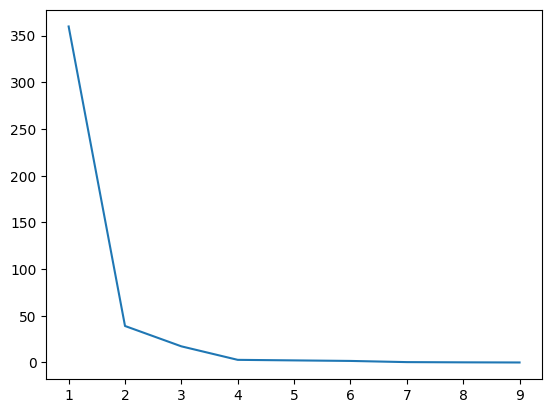

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming Database1 and U1 are already defined
Database1U = np.vstack((Database1, U1.T))  # Matrix 9x100 (number of samples = 100)

# Perform Singular Value Decomposition (SVD)
U, S, Vt = np.linalg.svd(Database1U, full_matrices=False)

K = [1, 3, 5, 7]
for k in K:
    # Reconstruct the matrix using the first k singular values
    Uk = U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :]

    # Display the mean of the 9th row of Uk
    # print(np.mean(Uk[8, :]))

    print("Erreur :", np.linalg.norm(Database1U - Uk) / np.linalg.norm(Database1U))

    # Plot histogram of the 9th row of Uk
    plt.figure()
    plt.hist(Uk[8, :], bins='auto', density=True)  # Normalization='probability'
    plt.title(f'{k}')
    plt.show()

# Plot histogram of the 9th row of the original Database1U matrix
plt.figure()
plt.hist(Database1U[8, :], bins='auto', density=True)  # Normalization='probability'
plt.title('U original')
plt.show()



# Singular values extraction and plotting
sing = S[:9]
x = np.arange(1, 10)
plt.figure()
plt.plot(x, sing)
plt.show()


## 4 - Design a meta-model

- 4.1 Referring to 3.1, use the generated LDBs (i.e. the collection $S:=\left\lbrace \mathbf{X},y\right\rbrace_{t=1,...,N}$ with $\mathbf{X}=\left[K_1,K_2,m,\Delta_y,t_1,F_1\right]^T$ and $y=u_{top}$, computed via matlab code) to conceive a metamodel $\tilde{y}=m(\mathbf{X})$ (ANN, others...) to predict the maximum displacement of the SDOF $u_{top}$.

- 4.2 Compute the following metrics :
$$RMSE = (\frac{1}{N}\sum_{t=1}^N(y-\tilde{y})^2)^{\frac{1}{2}}$$
$$R^2 = 1-\frac{\sum_{t=1}^N\left(y-\tilde{y}\right)^2}{\sum_{t=1}^N\left(y-\bar{y}\right)^2}$$
$$\epsilon_m = \frac{1}{N}\sum_{t=1}^N 100\frac{\left(y-\tilde{y}\right)}{y}$$
        
with $\bar{y} = \frac{1}{N}\sum_{t=1}^N \tilde{y}$

- 4.3 Calculate the two failure probabilities for each studied case (__T1.1__ to __T1.3__) and compare with the obtained ones in __Section 1__.

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Assuming Database3 and U3 are already defined
Database2U = np.vstack((Database3, U3.T))  # Matrix 9x100 (number of samples = 100)

P = Database2U[:8, :].T  # Parameters
U = Database2U[8, :].T  # Displacement

# Split data into training and testing sets
split_ratio = 0.8
train_P, test_P, train_U, test_U = train_test_split(P, U, train_size=split_ratio, random_state=1)

# Design models
model1 = LinearRegression()
num_trees = 100  # Number of trees in the forest
model2 = RandomForestRegressor(n_estimators=num_trees, random_state=1)

# Train models
model1.fit(train_P, train_U)
model2.fit(train_P, train_U)

# Predictions
predicted_U1 = model1.predict(test_P)
predicted_U2 = model2.predict(test_P)

# Evaluation of models
mse1 = np.sqrt(mean_squared_error(test_U, predicted_U1))  # RMSE
mae1 = mean_absolute_error(test_U, predicted_U1)
R2_1 = r2_score(test_U, predicted_U1)
EPSm1 = 100 / len(test_U) * np.max(np.sum((predicted_U1 - test_U) / test_U))

mse2 = np.sqrt(mean_squared_error(test_U, predicted_U2))  # RMSE
mae2 = mean_absolute_error(test_U, predicted_U2)
R2_2 = r2_score(test_U, predicted_U2)
EPSm2 = 100 / len(test_U) * np.max(np.sum((predicted_U2 - test_U) / test_U))

# Display results
print('Model: Linear Regression')
print(f'RMSE metric: {mse1}')
print(f'R2 metric: {R2_1}')
print(f'Epsilon_m metric: {EPSm1}')
print(f'Mean Absolute Error: {mae1}\n')

print('Model: Random Forest')
print(f'RMSE metric: {mse2}')
print(f'R2 metric: {R2_2}')
print(f'Epsilon_m metric: {EPSm2}')
print(f'Mean Absolute Error: {mae2}\n')





# PCA reduced databases for machine learning predictions

Database3U = np.vstack((Database3, U3.T))  # Matrix 9x100 (number of samples = 100)
P = Database3U.T

# Perform PCA
pca = PCA()
score = pca.fit_transform(P[:, :8])

# Selection of number of components explaining a given variance
variance_expliquee = 99  # percentage of variance to explain
cumulative_variance = np.cumsum(pca.explained_variance_ratio_) * 100
Nb_coef = np.searchsorted(cumulative_variance, variance_expliquee) + 1

# Reduce the number of parameters in the database
reduced_P = score[:, :Nb_coef]

# Split data into training and testing sets
train_P, test_P, train_U, test_U = train_test_split(reduced_P, U, train_size=split_ratio, random_state=1)

# Train models
model1.fit(train_P, train_U)
model2.fit(train_P, train_U)

# Predictions
predicted_U1 = model1.predict(test_P)
predicted_U2 = model2.predict(test_P)

# Evaluation of models
mse1 = np.sqrt(mean_squared_error(test_U, predicted_U1))  # RMSE
mae1 = mean_absolute_error(test_U, predicted_U1)
R2_1 = r2_score(test_U, predicted_U1)
EPSm1 = 100 / len(test_U) * np.max(np.sum((predicted_U1 - test_U) / test_U))

mse2 = np.sqrt(mean_squared_error(test_U, predicted_U2))  # RMSE
mae2 = mean_absolute_error(test_U, predicted_U2)
R2_2 = r2_score(test_U, predicted_U2)
EPSm2 = 100 / len(test_U) * np.max(np.sum((predicted_U2 - test_U) / test_U))

# Display results
print('Model: Linear Regression (with PCA)')
print(f'RMSE metric: {mse1}')
print(f'R2 metric: {R2_1}')
print(f'Epsilon_m metric: {EPSm1}')
print(f'Mean Absolute Error: {mae1}\n')

print('Model: Random Forest')
print(f'RMSE metric: {mse2}')
print(f'R2 metric: {R2_2}')
print(f'Epsilon_m metric: {EPSm2}')
print(f'Mean Absolute Error: {mae2}\n')



# Probability of failure ML models
Sum_mod = 0
Sum_ext = 0
for i in range(20-1):
    if 3 * test_P[i, 1] < predicted_U1[i]:
        Sum_ext += 1
    if 0.9 * test_P[i, 2] < predicted_U1[i]:
        Sum_mod += 1

Proba_mod = Sum_mod / (10*len(test_U))
Proba_ext = Sum_ext / (10*len(test_U))
print('Probability of moderate damage:')
print(Proba_mod)
print('Probability of hard damage:')
print(Proba_ext)

# Saving training data for Python
# Save X_train and y_train as separate files
np.save('X_train.npy', train_P)
np.save('y_train.npy', train_U)


Model: Linear Regression
RMSE metric: 5.551115123125783e-17
R2 metric: 0.0
Epsilon_m metric: 1.1102330381960354e-14
Mean Absolute Error: 5.551115123125783e-17

Model: Random Forest
RMSE metric: 4.440892098500626e-16
R2 metric: -63.0
Epsilon_m metric: 8.881864305568283e-14
Mean Absolute Error: 4.440892098500626e-16

Model: Linear Regression (with PCA)
RMSE metric: 5.551115123125783e-17
R2 metric: 0.0
Epsilon_m metric: 1.1102330381960354e-14
Mean Absolute Error: 5.551115123125783e-17

Model: Random Forest
RMSE metric: 4.440892098500626e-16
R2 metric: -63.0
Epsilon_m metric: 8.881864305568283e-14
Mean Absolute Error: 4.440892098500626e-16

Probability of moderate damage:
0.06
Probability of hard damage:
0.055


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns



# Machine learning predictions
Database2U = np.vstack([Database2, np.max(np.abs(Database2), axis=0)])
P = Database2U[:8, :].T
U = Database2U[8, :]

train_P, test_P, train_U, test_U = train_test_split(P, U, test_size=0.2, random_state=1)

# Train models
model1 = LinearRegression().fit(train_P, train_U)
model2 = RandomForestRegressor(n_estimators=100).fit(train_P, train_U)

# Predictions
predicted_U1 = model1.predict(test_P)
predicted_U2 = model2.predict(test_P)

# Evaluation
mse1 = np.sqrt(np.mean((predicted_U1 - test_U)**2))
mae1 = np.mean(np.abs(predicted_U1 - test_U))
R2_1 = 1 - np.sum((predicted_U1 - test_U)**2) / np.sum((test_U - np.mean(test_U))**2)

mse2 = np.sqrt(np.mean((predicted_U2 - test_U)**2))
mae2 = np.mean(np.abs(predicted_U2 - test_U))
R2_2 = 1 - np.sum((predicted_U2 - test_U)**2) / np.sum((test_U - np.mean(test_U))**2)

print('Linear Regression Model:')
print(f'RMSE: {mse1}, MAE: {mae1}, R2: {R2_1}')

print('Random Forest Model:')
print(f'RMSE: {mse2}, MAE: {mae2}, R2: {R2_2}')


Linear Regression Model:
RMSE: 0.46065569073337514, MAE: 0.1516846099675389, R2: 0.9922681769033874
Random Forest Model:
RMSE: 0.12895895161239937, MAE: 0.0941755830270509, R2: 0.9993940566616303
